In [1]:
!pip install tensorflow numpy pandas scikit-learn


In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array, load_img


In [3]:
import os
import shutil

# Define paths
dataset_path = "/kaggle/input/genderdata/UTKFace"  # Read-only source
output_path = "/kaggle/working/dataset_faces_by_age"  # Writeable destination

# Create directories for age categories
os.makedirs(f"{output_path}/baby", exist_ok=True)
os.makedirs(f"{output_path}/kid", exist_ok=True)
os.makedirs(f"{output_path}/young", exist_ok=True)
os.makedirs(f"{output_path}/old", exist_ok=True)

# Function to categorize based on age
def categorize_age(age):
    if age <= 3:
        return "baby"
    elif 4 <= age <= 12:
        return "kid"
    elif 13 <= age <= 35:
        return "young"
    else:
        return "old"

# Copy images to corresponding directories
for filename in os.listdir(dataset_path):
    if filename.endswith(".jpg"):
        parts = filename.split("_")
        if len(parts) >= 2:
            try:
                age = int(parts[0])  # Extract the age from the filename
                category = categorize_age(age)  # Categorize the age

                # Define source and destination paths
                source_file = os.path.join(dataset_path, filename)
                dest_file = os.path.join(output_path, category, filename)

                # Copy the file to the appropriate category folder
                shutil.copy(source_file, dest_file)
            except ValueError:
                # In case the filename doesn't have a valid age part
                print(f"Skipping invalid file: {filename}")

print("Dataset organized by age categories successfully!")


Dataset organized by age categories successfully!


In [4]:
import os
import shutil
import random

# Define paths
train_dir = "/kaggle/working/train"
val_dir = "/kaggle/working/val"

# Create directories for training and validation
for category in ['baby', 'kid', 'young', 'old']:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)

# Function to split dataset into training and validation
def split_dataset(source_dir, train_dir, val_dir, val_ratio=0.2):
    # Loop through each category
    for category in ['baby', 'kid', 'young', 'old']:
        category_dir = os.path.join(source_dir, category)
        # List all files in the category directory
        files = os.listdir(category_dir)
        # Shuffle files randomly
        random.shuffle(files)
        
        # Calculate the number of validation samples
        val_size = int(len(files) * val_ratio)
        
        # Split files into training and validation
        val_files = files[:val_size]
        train_files = files[val_size:]
        
        # Copy files to the respective directories
        for file in train_files:
            shutil.copy(os.path.join(category_dir, file), os.path.join(train_dir, category, file))
        for file in val_files:
            shutil.copy(os.path.join(category_dir, file), os.path.join(val_dir, category, file))

# Split the dataset into training and validation sets
split_dataset(output_path, train_dir, val_dir)

print("Dataset split into train and validation sets successfully!")


Dataset split into train and validation sets successfully!


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size and batch size
image_size = (224, 224)  # You can adjust this based on your model input size
batch_size = 32

# Define image data generators for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values between 0 and 1
    rotation_range=30,  # Randomly rotate images
    width_shift_range=0.2,  # Randomly shift images horizontally
    height_shift_range=0.2,  # Randomly shift images vertically
    shear_range=0.2,  # Randomly apply shear transformation
    zoom_range=0.2,  # Randomly zoom images
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'  # Fill any newly created pixels after transformations
)

val_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for validation set

# Create the training and validation data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',  # Using categorical labels (one-hot encoding)
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',  # Using categorical labels (one-hot encoding)
    shuffle=False
)

# Check class indices to verify if everything is in order
print("Class indices for training set:", train_generator.class_indices)


Found 18969 images belonging to 4 classes.
Found 4739 images belonging to 4 classes.
Class indices for training set: {'baby': 0, 'kid': 1, 'old': 2, 'young': 3}


In [7]:
# Print the number of images per class in the training set
print("Training Set:")
for class_name, class_index in train_generator.class_indices.items():
    print(f"{class_name}: {train_generator.classes.tolist().count(class_index)} images")

# Print the number of images per class in the validation set
print("\nValidation Set:")
for class_name, class_index in val_generator.class_indices.items():
    print(f"{class_name}: {val_generator.classes.tolist().count(class_index)} images")


Training Set:
baby: 1516 images
kid: 1216 images
old: 6881 images
young: 9356 images

Validation Set:
baby: 378 images
kid: 303 images
old: 1720 images
young: 2338 images


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import MobileNetV2
import tensorflow as tf

# Create the custom model
from tensorflow.keras.layers import MaxPooling2D, Conv2D,Dense,Dropout,Flatten
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model.trainable = False  # Freeze the base model
model = Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  
    tf.keras.layers.BatchNormalization(),
    Dropout(0.5),

    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  
    tf.keras.layers.BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  
    Dropout(0.3),

    Dense(4, activation='softmax')
])
# Compile the model
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0001, weight_decay=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
# Train the model
history1 = model.fit(
    train_generator,
    epochs=20,  # You can adjust the number of epochs
    validation_data=val_generator
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


593/593 ━━━━━━━━━━━━━━━━━━━━ 227s 352ms/step - accuracy: 0.3396 - loss: 8.2609 - val_accuracy: 0.6733 - val_loss: 6.5445
Epoch 2/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 200s 332ms/step - accuracy: 0.5943 - loss: 6.5480 - val_accuracy: 0.6999 - val_loss: 5.5397
Epoch 3/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 200s 334ms/step - accuracy: 0.6414 - loss: 5.5210 - val_accuracy: 0.7111 - val_loss: 4.6969
Epoch 4/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 201s 335ms/step - accuracy: 0.6578 - loss: 4.6550 - val_accuracy: 0.7314 - val_loss: 3.9487
Epoch 5/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 200s 333ms/step - accuracy: 0.6732 - loss: 3.9327 - val_accuracy: 0.7316 - val_loss: 3.3276
Epoch 6/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 200s 333ms/step - accuracy: 0.6915 - loss: 3.3067 - val_accuracy: 0.7371 - val_loss: 2.7949
Epoch 7/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 199s 331ms/step - accuracy: 0.6985 - loss: 2.7832 - val_accuracy: 0.7362 - val_loss: 2.3552
Epoch 8/20
593/593 ━━━━━━━━━━━━━━━━━━━━ 199s 332ms/step - accuracy: 0.7077 - loss: 2.34

In [ ]:
# Evaluate the model on the validation set
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import MobileNetV2
import tensorflow as tf
model = tf.keras.models.load_model("/kaggle/input/agemodel1/keras/default/1/age_classifier_model.h5")
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


In [9]:
import tensorflow as tf
from tensorflow.keras.models import load_model


# Step 2: Unfreeze the base model (MobileNetV2)
base_model = model.layers[0]  # MobileNetV2 is the first layer in your model
base_model.trainable = True   # Unfreeze all layers of MobileNetV2

# Step 3: Recompile with a lower learning rate (for stable fine-tuning)
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-5, weight_decay=1e-4),  # Reduce LR
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Step 4: Fine-tune the model
history_finetune = model.fit(
    train_generator,
    epochs=30,  # Adjust based on performance
    validation_data=val_generator
)


Epoch 1/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 278s 382ms/step - accuracy: 0.6442 - loss: 0.9876 - val_accuracy: 0.5839 - val_loss: 1.2666
Epoch 2/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 202s 337ms/step - accuracy: 0.7192 - loss: 0.8051 - val_accuracy: 0.6090 - val_loss: 1.0514
Epoch 3/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 204s 339ms/step - accuracy: 0.7301 - loss: 0.7533 - val_accuracy: 0.6620 - val_loss: 0.8630
Epoch 4/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 203s 338ms/step - accuracy: 0.7444 - loss: 0.7205 - val_accuracy: 0.7449 - val_loss: 0.7085
Epoch 5/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 202s 337ms/step - accuracy: 0.7572 - loss: 0.6916 - val_accuracy: 0.7778 - val_loss: 0.6429
Epoch 6/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 202s 336ms/step - accuracy: 0.7675 - loss: 0.6664 - val_accuracy: 0.7852 - val_loss: 0.6275
Epoch 7/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 202s 337ms/step - accuracy: 0.7767 - loss: 0.6511 - val_accuracy: 0.7911 - val_loss: 0.6219
Epoch 8/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 204s 339ms/step - accuracy: 0.7847 -

In [10]:
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

149/149 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.7782 - loss: 0.6068
Validation Loss: 0.4920288920402527
Validation Accuracy: 0.8235914707183838


In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,816,846 (29.82 MB)

 Trainable params: 2,593,988 (9.90 MB)

 Non-trainable params: 34,880 (136.25 KB)

 Optimizer params: 5,187,978 (19.79 MB)

In [ ]:
history2_finetune = model.fit(
    train_generator,
    epochs=10,  # Adjust based on performance
    validation_data=val_generator
)

In [ ]:
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

In [12]:
model.save("age_classifier_semioptimization.h5")

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Load and preprocess an image for prediction
img_path = '/path/to/image.jpg'  # Replace with the path to the image you want to classify
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Rescale to [0, 1]

# Make a prediction
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)

# Print the predicted class
class_names = ['baby', 'kid', 'old', 'young']
print(f"Predicted class: {class_names[predicted_class[0]]}")


In [ ]:
# Unfreeze the layers of the base model for fine-tuning
base_model.trainable = True

# Recompile the model after unfreezing
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0001, weight_decay=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model
history_finetune = model.fit(
    train_generator,
    epochs=20,  # Number of epochs for fine-tuning
    validation_data=val_generator
)


In [ ]:
model.save('age_classifier_model.h5')

In [ ]:
# Load the pre-trained ResNet50 model without the top layers
base_model = ResNet50(weights='imagenet', include_top=False)

# Add custom layers for our task
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(4, activation='softmax')(x)  # 4 categories: baby, kid, young, old

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model initially (only train the custom layers)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32)


In [ ]:
# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_acc}')


In [ ]:
# Assuming new_images is a list of images to predict
new_image_path = '/kaggle/input/gendertest/mtcnn4.jpg'
new_image = load_img(new_image_path, target_size=(224, 224))
new_image = img_to_array(new_image)
new_image = np.expand_dims(new_image, axis=0)  # Add batch dimension

prediction = model.predict(new_image)
predicted_label = np.argmax(prediction)
categories = ['baby', 'kid', 'old', 'young']
predicted_category = categories[predicted_label]

print(f'Predicted category: {predicted_category}')


In [2]:
!pip install mtcnn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.1 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.7 MB/s eta 0:00:00


In [ ]:
!pip install lz4


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
['kid']


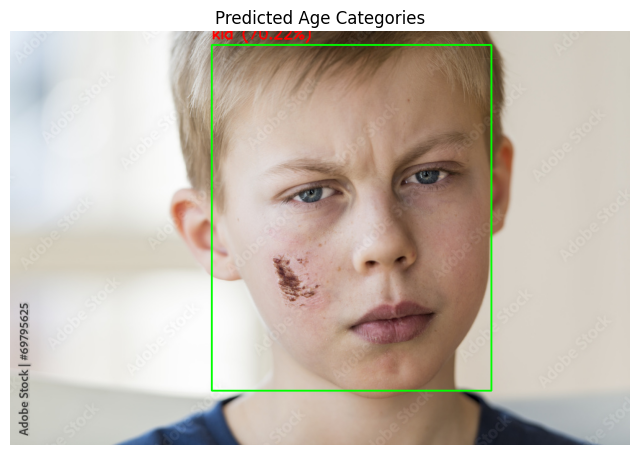

In [11]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from mtcnn import MTCNN

model=tf.keras.models.load_model("/kaggle/input/agemodel3/keras/default/1/age_classifier_finalfinal.h5")
# Define class labels
class_labels = ["baby", "kid", "old", "young"]

# Initialize MTCNN detector
detector = MTCNN()

def detect_and_crop_faces(image_path, model_input_size=(224, 224)):
    # Read image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB

    # Detect faces
    faces = detector.detect_faces(img_rgb)
    
    cropped_faces = []
    face_boxes = []  # Store face coordinates for drawing

    for face in faces:
        x, y, width, height = face['box']
        x, y = max(0, x), max(0, y)

        # Add margin for better context
        margin = 20
        x = max(0, x - margin)
        y = max(0, y - margin)
        width = min(img_rgb.shape[1], x + width + 2 * margin) - x
        height = min(img_rgb.shape[0], y + height + 2 * margin) - y
        cropped_face = img_rgb[y:y+height, x:x+width]

        # Resize to match model input size
        cropped_face_resized = cv2.resize(cropped_face, model_input_size)

        # Normalize (assuming model expects values in [0, 1] range)
        cropped_face_normalized = cropped_face_resized / 255.0

        cropped_faces.append(cropped_face_normalized)
        face_boxes.append((x, y, width, height))

    return img_rgb, cropped_faces, face_boxes

def predict_age_category(image_path):
    # Detect and crop faces
    img_rgb, cropped_faces, face_boxes = detect_and_crop_faces(image_path)

    if len(cropped_faces) == 0:
        print("No faces detected!")
        return

    # Convert list of cropped faces to NumPy array
    cropped_faces_batch = np.array(cropped_faces)

    # Predict age category
    predictions = model.predict(cropped_faces_batch)

    # Interpret predictions
    predicted_classes = np.argmax(predictions, axis=1)  # Get class index
    predicted_labels = [class_labels[idx] for idx in predicted_classes]  # Convert to labels
    print(predicted_labels)

    # Display results
    for i, (x, y, width, height) in enumerate(face_boxes):
        label = predicted_labels[i]
        confidence = np.max(predictions[i]) * 100  # Get highest probability
        text = f"{label} ({confidence:.2f}%)"
        
        # Draw rectangle around face
        cv2.rectangle(img_rgb, (x, y), (x + width, y + height), (0, 255, 0), 2)
        
        # Put label text
        cv2.putText(img_rgb, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)

    # Show final image with predictions
    plt.figure(figsize=(8, 6))
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.title("Predicted Age Categories")
    plt.show()

# Example usage
predict_age_category("/kaggle/input/gendertest/gendertest1.jpg")
